# Similarity Model Comparison Challenge
This is an assignment for my thinkful data science course. 
Raj Prasad
May 2019


[html version](https://daddyprasad5.github.io/similarity_model_comparison.html) - with all the code hidden away for a quick read

[jupyter notebook version](https://github.com/daddyprasad5/thinkful/blob/master/similarity_model_comparison.ipynb) - with all the code exposed in an interactive notebook

In [164]:
#imports
import numpy as np
import pandas as pd
import xlrd
import glob
import os
from sklearn import linear_model, neighbors
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse, rmse
import seaborn as sns
from scipy.stats import zscore
from scipy.stats.mstats import winsorize
import scipy.stats as stats
from IPython.display import display, HTML



In [ ]:
#get immigration data
#datasource: https://www.un.org/en/development/desa/population/migration/data/empirical2/migrationflows.asp
def join_excel_files_to_df(path=""):
    data = pd.DataFrame()
    files = glob.glob("{}*.xlsx".format(path))
    for f in files:
        df = pd.read_excel(f,skiprows=20)
        df["country"] = os.path.splitext(os.path.splitext(os.path.basename(f))[0])[0]
        data = data.append(df,ignore_index=True)
    return data

path = "UN_MigFlow_All_CountryFiles/"
mig_df = join_excel_files_to_df(path)

In [66]:
mig_df.head()

,Type,Coverage,AreaName,RegName,1980,1981,1982,1983,1984,1985,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,country
0,Immigrants,Citizens,Northern America,Northern America,..,..,..,..,..,..,...,..,..,..,..,..,..,1,1,NaN,Canada
1,Immigrants,Foreigners,Africa,Eastern Africa,1471,1641,1426,1094,1187,1134,...,7083,6750,6669,6705,6922,8591,8956,8846,NaN,Canada
2,Immigrants,Foreigners,Africa,Middle Africa,33,27,44,32,42,30,...,2802,2834,2951,3034,3255,3369,3146,4602,NaN,Canada
3,Immigrants,Foreigners,Africa,Northern Africa,1100,1268,1348,936,842,840,...,11323,12705,11750,13456,16320,19271,15712,15453,NaN,Canada
4,Immigrants,Foreigners,Africa,Southern Africa,1041,1126,791,387,297,327,...,1012,1148,1230,1184,1235,1306,1049,1348,NaN,Canada


In [132]:
#get happiness data
#https://s3.amazonaws.com/happiness-report/2019/Chapter2OnlineData.xls
happ_df = pd.read_excel("https://s3.amazonaws.com/happiness-report/2019/Chapter2OnlineData.xls")

In [133]:
happ_df.tail()

,Country name,Year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,...,GINI index (World Bank estimate),"GINI index (World Bank estimate), average 2000-16","gini of household income reported in Gallup, by wp5-year","Most people can be trusted, Gallup","Most people can be trusted, WVS round 1981-1984","Most people can be trusted, WVS round 1989-1993","Most people can be trusted, WVS round 1994-1998","Most people can be trusted, WVS round 1999-2004","Most people can be trusted, WVS round 2005-2009","Most people can be trusted, WVS round 2010-2014"
1699,Zimbabwe,2014,4.184451,7.562753,0.765839,52.380001,0.642034,-0.048634,0.820217,0.725214,...,NaN,0.432,0.601080,NaN,NaN,NaN,NaN,0.116683,NaN,0.082942
1700,Zimbabwe,2015,3.703191,7.556052,0.735800,53.799999,0.667193,-0.097354,0.810457,0.715079,...,NaN,0.432,0.655137,NaN,NaN,NaN,NaN,0.116683,NaN,0.082942
1701,Zimbabwe,2016,3.735400,7.538829,0.768425,54.400002,0.732971,-0.068105,0.723612,0.737636,...,NaN,0.432,0.596690,NaN,NaN,NaN,NaN,0.116683,NaN,0.082942
1702,Zimbabwe,2017,3.638300,7.549491,0.754147,55.000000,0.752826,-0.069670,0.751208,0.806428,...,NaN,0.432,0.581484,NaN,NaN,NaN,NaN,0.116683,NaN,0.082942
1703,Zimbabwe,2018,3.616480,7.553395,0.775388,55.599998,0.762675,-0.038384,0.844209,0.710119,...,NaN,0.432,0.541772,NaN,NaN,NaN,NaN,0.116683,NaN,0.082942


In [134]:
happ_df.describe()

,Year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect,...,GINI index (World Bank estimate),"GINI index (World Bank estimate), average 2000-16","gini of household income reported in Gallup, by wp5-year","Most people can be trusted, Gallup","Most people can be trusted, WVS round 1981-1984","Most people can be trusted, WVS round 1989-1993","Most people can be trusted, WVS round 1994-1998","Most people can be trusted, WVS round 1999-2004","Most people can be trusted, WVS round 2005-2009","Most people can be trusted, WVS round 2010-2014"
count,1704.000000,1704.000000,1676.000000,1691.000000,1676.000000,1675.000000,1622.000000,1608.000000,1685.000000,1691.000000,...,643.000000,1502.000000,1335.000000,180.000000,125.000000,220.000000,618.000000,491.000000,630.000000,671.000000
mean,2012.332160,5.437155,9.222456,0.810570,63.111971,0.733829,0.000079,0.751315,0.709368,0.265679,...,0.370000,0.385438,0.447771,0.226295,0.390480,0.283925,0.249574,0.268070,0.264336,0.237493
std,3.688072,1.121149,1.185794,0.119210,7.583622,0.144115,0.163365,0.186074,0.107984,0.084707,...,0.083232,0.082396,0.108505,0.119079,0.123309,0.113226,0.118126,0.145120,0.160169,0.157482
min,2005.000000,2.661718,6.457201,0.290184,32.299999,0.257534,-0.336385,0.035198,0.362498,0.083426,...,0.240000,0.211000,0.200969,0.066618,0.176535,0.066020,0.048720,0.075872,0.038242,0.031518
25%,2009.000000,4.610970,8.304428,0.747512,58.299999,0.638436,-0.115534,0.696083,0.621855,0.205414,...,0.305000,0.321429,0.368424,0.139773,0.290300,0.223553,0.176876,0.155833,0.144976,0.118725
50%,2012.000000,5.339557,9.406206,0.833098,65.000000,0.752731,-0.022080,0.805775,0.718541,0.254544,...,0.352000,0.371000,0.426541,0.198450,0.380174,0.292383,0.229924,0.232000,0.198380,0.193531
75%,2015.000000,6.273522,10.193060,0.904432,68.300003,0.848155,0.093522,0.876458,0.801530,0.314896,...,0.428000,0.432200,0.514803,0.281627,0.478149,0.341741,0.294242,0.385469,0.391370,0.335000
max,2018.000000,8.018934,11.770276,0.987343,76.800003,0.985178,0.677743,0.983276,0.943621,0.704590,...,0.634000,0.626000,0.961435,0.640332,0.571719,0.594595,0.647737,0.637185,0.737305,0.661757


In [135]:
happ_df.describe(include="O")

,Country name
count,1704
unique,165
top,Argentina
freq,13


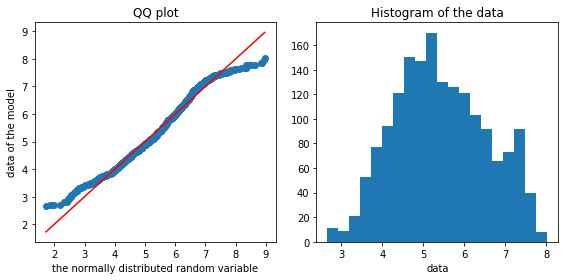

Jarque-Bera test statistics is 40.946411797125656 and p value is 1.2841023799836648e-09
Normality test statistics is 102.22316072900054 and p value is 6.346330515913222e-23


In [136]:
#the target variable is normal-like, but not statistically normal

def check_normality(data): 
    rand_nums = np.random.normal(np.mean(data), np.std(data), len(data))

    plt.figure(figsize=(8,4))
    
    x = np.sort(rand_nums)
    y = data.sort_values()

    plt.subplot(1,2,1)
    plt.scatter(np.sort(rand_nums), data.sort_values())
    plt.xlabel("the normally distributed random variable")
    plt.ylabel("data of the model")
    plt.plot(x, x, c="red")
    plt.title("QQ plot")

    plt.subplot(1,2,2)
    plt.hist(data, bins = 20)
    plt.xlabel("data")
    plt.title("Histogram of the data")

    plt.tight_layout()
    plt.show()

    from scipy.stats import jarque_bera
    from scipy.stats import normaltest

    jb_stats = jarque_bera(data)
    norm_stats = normaltest(data)

    print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
    print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))
    
check_normality(happ_df["Life Ladder"])

In [137]:
#find missing values

def find_nulls(df): 
    total_missing = df.isnull().sum().sort_values(ascending=False)
    percent_missing = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    return pd.concat([total_missing, percent_missing], axis=1, keys=['Total', 'Percent'])

nulls_df = find_nulls(happ_df).reset_index()
nulls_df.columns = ["column", "row_count", "percent_missing"]
nulls_df

,column,row_count,percent_missing
0,"Most people can be trusted, WVS round 1981-1984",1579,0.926643
1,"Most people can be trusted, Gallup",1524,0.894366
2,"Most people can be trusted, WVS round 1989-1993",1484,0.870892
3,"Most people can be trusted, WVS round 1999-2004",1213,0.711854
4,"Most people can be trusted, WVS round 1994-1998",1086,0.637324
5,"Most people can be trusted, WVS round 2005-2009",1074,0.630282
6,GINI index (World Bank estimate),1061,0.622653
7,"Most people can be trusted, WVS round 2010-2014",1033,0.606221
8,"gini of household income reported in Gallup, b...",369,0.216549
9,"GINI index (World Bank estimate), average 2000-16",202,0.118545


In [139]:
#remove columns where the nulls are greater than 15%
happ_df = happ_df.drop(nulls_df.loc[nulls_df.percent_missing > .15, "column"].values, axis=1)


Index(['Country name', 'Year', 'Life Ladder', 'Log GDP per capita',
       'Social support', 'Healthy life expectancy at birth',
       'Freedom to make life choices', 'Generosity',
       'Perceptions of corruption', 'Positive affect', 'Negative affect',
       'Confidence in national government', 'Democratic Quality',
       'Delivery Quality', 'Standard deviation of ladder by country-year',
       'Standard deviation/Mean of ladder by country-year',
       'GINI index (World Bank estimate), average 2000-16'],
      dtype='object')

In [140]:
#interpolate based on the surrounding country / year values. Display remaining nulls

#interpolate missing values, as possible

col_list = ['Social support', 'Healthy life expectancy at birth',
       'Freedom to make life choices', 'Generosity',
       'Perceptions of corruption', 'Positive affect', 'Negative affect',
       'Confidence in national government', 'Democratic Quality',
       'Delivery Quality', 'Standard deviation of ladder by country-year',
       'Standard deviation/Mean of ladder by country-year',
       'GINI index (World Bank estimate), average 2000-16']

#add a key and change sort order to the most logical sequence 
# for interpolation: first by state and  then by year
happ_df["new_pk"] = happ_df["Country name"] + happ_df["Year"].map(str)
happ_df.sort_values(by="new_pk").head()

for col in col_list:
    happ_df.loc[:, col].interpolate(inplace=True)

nulls_df = find_nulls(happ_df)
nulls_df[nulls_df.Percent != 0]

,Total,Percent
Log GDP per capita,28,0.016432
"GINI index (World Bank estimate), average 2000-16",11,0.006455


In [141]:
#drop the remaining few rows with nulls
happ_df = happ_df.loc[np.isnan(happ_df["Log GDP per capita"]) == False, :]
happ_df = happ_df.loc[np.isnan(happ_df["GINI index (World Bank estimate), average 2000-16"]) == False, :]


In [158]:
cont_cols = ['Life Ladder','Log GDP per capita',
       'Social support', 'Healthy life expectancy at birth',
       'Freedom to make life choices', 'Generosity',
       'Perceptions of corruption', 'Positive affect', 'Negative affect',
       'Confidence in national government', 'Democratic Quality',
       'Delivery Quality', 'Standard deviation of ladder by country-year',
       'Standard deviation/Mean of ladder by country-year',
       'GINI index (World Bank estimate), average 2000-16']

np.abs(happ_df[cont_cols].corr()).loc[:,"Life Ladder"].sort_values(ascending=False)


Life Ladder                                          1.000000
Log GDP per capita                                   0.776588
Standard deviation/Mean of ladder by country-year    0.753680
Healthy life expectancy at birth                     0.732576
Social support                                       0.698006
Delivery Quality                                     0.694389
Democratic Quality                                   0.600745
Positive affect                                      0.534806
Freedom to make life choices                         0.506277
Perceptions of corruption                            0.439077
Negative affect                                      0.269183
Generosity                                           0.204171
GINI index (World Bank estimate), average 2000-16    0.202186
Standard deviation of ladder by country-year         0.192755
Confidence in national government                    0.101333
Name: Life Ladder, dtype: float64

In [166]:
#find some powerful continuous variables

cont_cols = ['Life Ladder','Log GDP per capita',
       'Social support', 'Healthy life expectancy at birth',
       'Freedom to make life choices', 'Generosity',
       'Perceptions of corruption', 'Positive affect', 'Negative affect',
       'Confidence in national government', 'Democratic Quality',
       'Delivery Quality', 'Standard deviation of ladder by country-year',
       'GINI index (World Bank estimate), average 2000-16']

#take the 5 with the highest correlation with sales price 
cont_corrs = np.abs(happ_df[cont_cols].corr()).loc[:,"Life Ladder"].sort_values(ascending=False)
top_cont = cont_corrs.head(10)[1:6].index.values

features = pd.DataFrame()
#add the new columns to the features dataframe
for cont in top_cont: 
    features[cont] = happ_df[cont]

print(features.columns)

Index(['Log GDP per capita', 'Healthy life expectancy at birth',
       'Social support', 'Delivery Quality', 'Democratic Quality'],
      dtype='object')


In [167]:
#build & compare some linear regression models

#Model CV implementations, predictions and evaluations for lasso, ridge and elasticnet

Y = happ_df['Life Ladder']
X = features

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

alphas = [np.power(10.0,p) for p in np.arange(-10,40,1)]
l1_ratio=[.1, .5, .7, .9, .95, .99, 1]

lrm = LinearRegression()
lrm.fit(X_train, y_train)

lasso_cv = LassoCV(alphas=alphas, cv=5)
lasso_cv.fit(X_train, y_train)

ridge_cv = RidgeCV(alphas=alphas, cv=5)
ridge_cv.fit(X_train, y_train)

elasticnet_cv = ElasticNetCV(alphas=alphas, cv=5, l1_ratio=l1_ratio)
elasticnet_cv.fit(X_train, y_train)

# We are making predictions here

def predict_and_evaluate(models, model_names, X_train, y_train, X_test):
    
    i = 0
    best_alpha = []
    r_squared_train = []
    r_squared_test = []
    mean_abs_err = []
    mean_sq_err = []
    rt_mean_sq_err = []
    mean_abs_perc_err = []
        
    for model in models: 
        y_preds_train = model.predict(X_train)
        y_preds_test = model.predict(X_test)
        
        if (getattr(model, "alpha_", False)):
            best_alpha.append(model.alpha_)
        else: 
            best_alpha.append(None)
        r_squared_train.append(model.score(X_train, y_train))
        r_squared_test.append(model.score(X_test, y_test))
        mean_abs_err.append(mean_absolute_error(y_test, y_preds_test))
        mean_sq_err.append(mse(y_test, y_preds_test))
        rt_mean_sq_err.append(rmse(y_test, y_preds_test))
        mean_abs_perc_err.append(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100)
        i += 1
    summary = pd.DataFrame({"best_alpha": best_alpha, "r_squared_train": r_squared_train, 
                        "r_squared_test": r_squared_test, "mean_abs_err": mean_abs_err, 
                        "mean_sq_err": mean_sq_err, "rt_mean_sq_err": rt_mean_sq_err,
                        "mean_abs_perc_err": mean_abs_perc_err})
    summary.index = model_names
    return summary
        
summ_results = predict_and_evaluate([lrm, lasso_cv, ridge_cv, elasticnet_cv],["lrm", "lasso_cv", "ridge_cv", "elasticnet_cv"], X_train, y_train, X_test)
summ_results

,best_alpha,r_squared_train,r_squared_test,mean_abs_err,mean_sq_err,rt_mean_sq_err,mean_abs_perc_err
lrm,NaN,0.698743,0.688171,0.492996,0.388542,0.623331,9.587819
lasso_cv,0.001,0.698646,0.689198,0.492586,0.387263,0.622304,9.572223
ridge_cv,0.100,0.698737,0.688430,0.492862,0.388219,0.623073,9.583585
elasticnet_cv,0.001,0.698646,0.689198,0.492586,0.387263,0.622304,9.572223


They're all extremely close.  The best r-squared on the test set is the lrm model: .699 

In [170]:
#create and compare some K closest neighbors models

# these models require features to be normalized, so we'll use the z-scores for each feature
for col in X.columns:
    X[col] = stats.zscore(X[col])

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

models = []
model_names = []
for k in range(1, 11):
    model = neighbors.KNeighborsRegressor(n_neighbors=k)
    model.fit(X_train, y_train)
    models.append(model)
    model_names.append("k={}".format(k))
print("without weighted distance")
display(predict_and_evaluate(models,model_names, X_train, y_train, X_test))

models = []
model_names = []
for k in range(1, 11):
    model = neighbors.KNeighborsRegressor(n_neighbors=k, weights="distance")
    model.fit(X_train, y_train)
    models.append(model)
    model_names.append("k={}".format(k))
print("with weighted distance")
display(predict_and_evaluate(models,model_names, X_train, y_train, X_test))
    


without weighted distance


,best_alpha,r_squared_train,r_squared_test,mean_abs_err,mean_sq_err,rt_mean_sq_err,mean_abs_perc_err
k=1,None,1.000000,0.798733,0.364318,0.250780,0.500780,7.174281
k=2,None,0.949159,0.841826,0.328423,0.197087,0.443944,6.553970
k=3,None,0.927395,0.837995,0.334616,0.201860,0.449288,6.645675
k=4,None,0.907013,0.840516,0.338774,0.198719,0.445779,6.712999
k=5,None,0.894446,0.844358,0.336377,0.193931,0.440376,6.683937
k=6,None,0.885553,0.842565,0.338156,0.196165,0.442906,6.724543
k=7,None,0.877491,0.841305,0.339878,0.197735,0.444674,6.738409
k=8,None,0.869070,0.833875,0.346133,0.206994,0.454966,6.865702
k=9,None,0.862266,0.826645,0.351123,0.216002,0.464760,6.958906
k=10,None,0.854929,0.822828,0.354237,0.220758,0.469849,6.997454


with weighted distance


,best_alpha,r_squared_train,r_squared_test,mean_abs_err,mean_sq_err,rt_mean_sq_err,mean_abs_perc_err
k=1,None,1.0,0.798733,0.364318,0.250780,0.500780,7.174281
k=2,None,1.0,0.846579,0.325988,0.191164,0.437223,6.489738
k=3,None,1.0,0.850235,0.323440,0.186608,0.431982,6.435600
k=4,None,1.0,0.855207,0.321370,0.180414,0.424752,6.373465
k=5,None,1.0,0.857845,0.321438,0.177126,0.420864,6.393974
k=6,None,1.0,0.857584,0.320963,0.177451,0.421249,6.387269
k=7,None,1.0,0.857600,0.320849,0.177432,0.421226,6.372079
k=8,None,1.0,0.853877,0.325065,0.182071,0.426698,6.452231
k=9,None,1.0,0.850178,0.326795,0.186679,0.432064,6.490353
k=10,None,1.0,0.848197,0.329494,0.189148,0.434912,6.527619


k = 7 looks like the best k-nearest-neighbors model with an r-squared on the test data of .858.  

# Comparison and Selection

The k-nearest-neighbors model with weighted distances is the best predictor by every measure.  Clearly - for prediction - I prefer this model. 

However, for explanation of the forces driving a country's average happiness, the linear regression model is still very useful.  Given the purpose of this kind of model - influencing government policy to improve world happiness - I would invest more time in the linear regression model so I can more quantitatively describe which variables are most important. 